# Homework 6 is a bitch
For that reason I am walking through making a rnn to predict stock prices in a slow manner.

I will start with the absolute basics: 

## 1 (COMPLETE)
To start, I will be predicting AAPL stock only

I will only be looking at closing price

I will use the log values

I will predict price of the next day

## 1.1 (COMPLETE) - keras is easier so going with that
Implement the same thing in tensorflow to see what is easier


## 2 (COMPLETE)

After I prove that I can do that, I will predict for the 5 values




# Data Preprocessing

In [1]:
# IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable


In [2]:
# import the csv of AAPL data

# bring in dataset with the dates as the index
df = pd.read_csv('stock_data/AAPL_data.csv')

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2015-11-09,30.452499,30.012501,30.240000,30.142500,135485600.0,27.699379,AAPL
1,2015-11-10,29.517500,29.014999,29.225000,29.192499,236511600.0,26.826374,AAPL
2,2015-11-11,29.355000,28.802500,29.092501,29.027500,180872000.0,26.674749,AAPL
3,2015-11-12,29.205000,28.912500,29.065001,28.930000,130102400.0,26.585155,AAPL
4,2015-11-13,28.892500,28.067499,28.799999,28.084999,183249600.0,25.808641,AAPL


In [3]:
# give some details of the dataframe
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,49.444204,48.407873,48.914472,48.952754,1.347417e+08,47.438863
std,23.457304,22.645781,23.079929,23.070998,6.231811e+07,23.537665
min,22.917500,22.367500,22.500000,22.584999,2.880380e+07,20.994093
25%,33.083750,32.792500,32.875000,33.019999,9.395100e+07,31.086031
50%,43.750000,43.087502,43.417500,43.522499,1.180676e+08,41.609699
75%,55.631250,54.321249,55.018749,55.056250,1.589832e+08,53.511896
max,137.979996,130.529999,137.589996,134.179993,5.334788e+08,133.948898


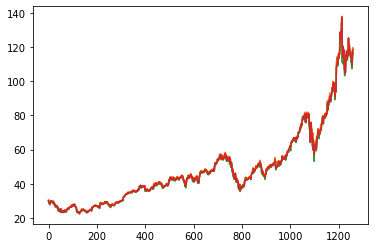

In [4]:
# show a plot of the prices for some of the values

df['Close'].plot()
df['High'].plot()
df['Low'].plot()
df['Open'].plot()

plt.show()

## Modify the data
We are taking the log of the close price

In [5]:
# Create new dataframe of just close price and normalize using MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

aug_df = df[['Close']]
aug_df['Close'] = scaler.fit_transform(aug_df['Close'].values.reshape(-1, 1))


aug_df.head()

C:\Users\Tyler\Anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close
0,-0.864555
1,-0.881581
2,-0.884538
3,-0.886285
4,-0.901429


In [6]:
aug_5_feat = df[['Close', 'Open', 'High', 'Low', 'Volume']]
aug_5_feat.head()

,Close,Open,High,Low,Volume
0,30.142500,30.240000,30.452499,30.012501,135485600.0
1,29.192499,29.225000,29.517500,29.014999,236511600.0
2,29.027500,29.092501,29.355000,28.802500,180872000.0
3,28.930000,29.065001,29.205000,28.912500,130102400.0
4,28.084999,28.799999,28.892500,28.067499,183249600.0


## Split the data into train and prediction
We will be predicting the next day value

In [7]:
print(aug_df)

         Close
0    -0.864555
1    -0.881581
2    -0.884538
3    -0.886285
4    -0.901429
...        ...
1254  0.544603
1255  0.574533
1256  0.655361
1257  0.728483
1258  0.722389

[1259 rows x 1 columns]


In [8]:
print(len(aug_df))

def split_train_pred(df, w):
    # w is the size of the window
    df_raw = df.to_numpy()
    data = []
    
    for i in range(len(df) - w):
        data.append(df_raw[i:i+w])
    
    data = np.array(data)
    test_set_size = int(np.round(.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x = data[:train_set_size, :-1, :]
    y = data[:train_set_size, -1, :]
    
    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
        
    return x, y, x_test, y_test

1259


In [9]:
x_5, y_5, x_5_test, y_5_test = split_train_pred(aug_5_feat, 20)

In [10]:
print(x_5.shape)

(991, 19, 5)


In [11]:
x, y, x_test, y_test = split_train_pred(aug_df, 20)
# x is the training close prices
# y is the next day prediction training price

print(x.shape)

print('Length of x:', len(x))
print('Length of y:', len(y))
print('Length of x test:', len(x_test))
print('Length of y test:', len(y_test))
        

(991, 19, 1)
Length of x: 991
Length of y: 991
Length of x test: 248
Length of y test: 248


In [12]:
print(x.shape)
x_train_tf = np.reshape(x, (x.shape[0], 1, x.shape[1]))
y_train_tf = np.array(y)
x_test_tf = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_test_tf = np.array(y_test)

(991, 19, 1)


In [13]:
# convert the x and y to tensors
x_train = torch.from_numpy(x).type(torch.Tensor)
y_train = torch.from_numpy(y).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


# Create LSTM model (pytorch)

In [14]:
# define common values
input_dim = 1 # this is 1 because we are only inputting the close price
hidden_dim = 32
num_layers = 2
output_dim = 1 # this is 1 because we are only predicting the close price
num_epochs = 100

In [15]:
class MyRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(MyRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # batch first means the input should look like (batch, sequence, features)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, inputs):
        h0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_dim).requires_grad_()
        
        c0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(inputs, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [16]:
model = MyRNN(input_dim, hidden_dim, num_layers, output_dim)

criterion = nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=.01)

In [17]:
hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    
    loss = criterion(y_train_pred, y_train)
    print('Epoch ', t, ' MSE: ', loss.item())
    hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    

Epoch 
 0  MSE:  0.3881295323371887
Epoch  1  MSE:  0.20706184208393097
Epoch  2  MSE:  0.06459084153175354
Epoch  3  MSE:  0.07776875048875809
Epoch  4  MSE:  0.0624023899435997
Epoch  5  MSE:  0.033867184072732925
Epoch  6  MSE:  0.033574603497982025
Epoch  7  MSE:  0.04120360687375069
Epoch  8  MSE:  0.045556969940662384
Epoch 
 9  MSE:  0.044762589037418365
Epoch 
 10  MSE:  0.04051840677857399
Epoch  11  MSE:  0.03544369712471962
Epoch  12  MSE:  0.03192939981818199
Epoch  13  MSE:  0.031292982399463654
Epoch  14  MSE:  0.0331089086830616
Epoch  15  MSE:  0.03538966178894043
Epoch  16  MSE:  0.03608962893486023
Epoch  17  MSE:  0.034723445773124695
Epoch  18  MSE:  0.032373491674661636
Epoch  19  MSE:  0.030441494658589363
Epoch  20  MSE:  0.029643122106790543
Epoch  21  MSE:  0.029851946979761124
Epoch  22  MSE:  0.030470309779047966
Epoch  23  MSE:  0.030863814055919647
Epoch  24  MSE:  0.030638275668025017
Epoch  25  MSE:  0.029738223180174828
Epoch  26  MSE:  0.028412403538823

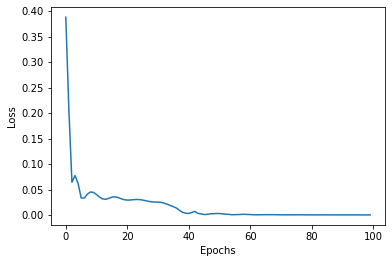

In [18]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

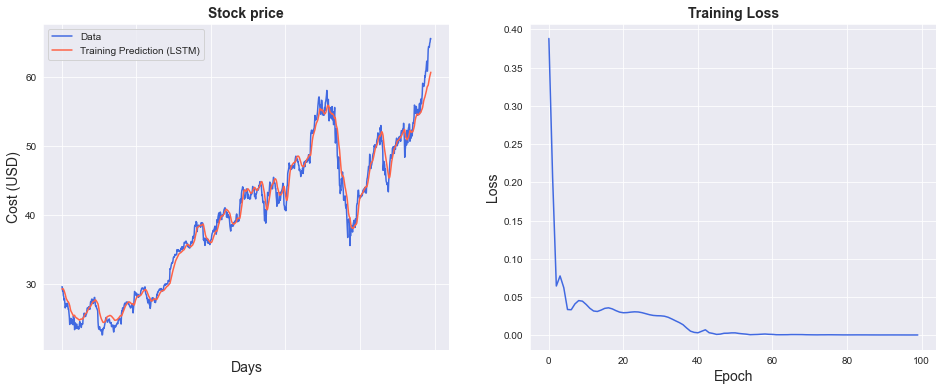

In [19]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# Build Model (Tensorflow)

In [20]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [21]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 19)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [22]:
model.fit(x_train_tf, y_train_tf, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_2479]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
print(type(x_test_tf))
print(y_train_tf.shape)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(x_train_tf)
testPredict = model.predict(x_test_tf)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train_tf)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test_tf)

In [ ]:
print(trainY.shape)
print(testY.shape)

In [ ]:
look_back = 19

# shift train predictions for plotting
trainPredictPlot = np.empty_like(aug_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(aug_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)-19:len(aug_df)-1, :] = testPredict
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(aug_df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(aug_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# AYEEEEE WE'RE LEARNING
Let's make some predictions

In [ ]:
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [ ]:
lookback = 20

trainPredictPlot = np.empty_like(aug_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(aug_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(aug_df)-1, :] = y_test_pred

original = scaler.inverse_transform(aug_df['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()
fig.write_image('fig1.png')